⭐ 2️⃣ MA (Moving Average)

Uses past errors (shocks) to predict.

📌 Example:
If yesterday’s prediction error was high, adjust today.

When to use:
When noise/shocks influence data.

                                  Open         High          Low        Close  \
Date                                                                            
2024-01-01 00:00:00+05:30  1078.368009  1078.368009  1060.770676  1064.812622   
2024-01-02 00:00:00+05:30  1070.974097  1087.437802  1064.221074  1082.212769   
2024-01-03 00:00:00+05:30  1082.409874  1083.543621  1067.375718  1069.593872   
2024-01-04 00:00:00+05:30  1072.699249  1112.626021  1070.776898  1109.619263   
2024-01-05 00:00:00+05:30  1109.077063  1115.140042  1101.239634  1107.056030   
...                                ...          ...          ...          ...   
2024-12-27 00:00:00+05:30   895.364086   904.694956   892.386157   901.270325   
2024-12-30 00:00:00+05:30   901.270301   905.290494   892.088353   896.853027   
2024-12-31 00:00:00+05:30   892.386134   910.402630   886.529515   907.970642   
2025-01-01 00:00:00+05:30   906.283137   915.713246   904.297850   913.529419   
2025-01-02 00:00:00+05:30   

C:\Anaconda3\envs\ssai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order=(0, 0, 1), Trend=c, RMSE(SCALED)=0.5352
Order=(0, 0, 1), Trend=ct, RMSE(SCALED)=0.6197
Order=(0, 0, 2), Trend=n, RMSE(SCALED)=0.2005


C:\Anaconda3\envs\ssai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order=(0, 0, 2), Trend=t, RMSE(SCALED)=1.0373
Order=(0, 0, 2), Trend=c, RMSE(SCALED)=0.5320
Order=(0, 0, 2), Trend=ct, RMSE(SCALED)=0.6106

Selecting Best ARIMA MA Model...

BEST MODEL FOUND
-----------------
Order : (0, 0, 1)
Trend : n
Scaled RMSE : 0.1960

Final Best Model Re-trained Successfully!

FINAL MODEL PERFORMANCE (REAL PRICES)
--------------------------------------
Real RMSE : 70.7051
Real MAPE : 0.0633


C:\Anaconda3\envs\ssai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


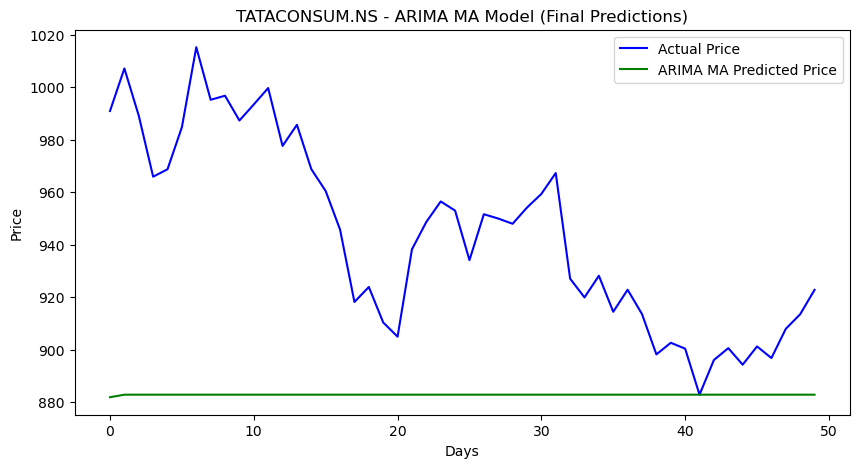

In [2]:
# ========================================================
# 0️⃣ IMPORT LIBRARIES
# ========================================================

import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt


# ========================================================
# 1️⃣ DOWNLOAD DATA
# ========================================================

ticker = yf.Ticker("TATACONSUM.NS")
stk_data = ticker.history(start="2024-01-01", end="2025-01-03")

print(stk_data)
stk_data.info()


# ========================================================
# 2️⃣ NORMALIZATION (MinMaxScaler)
# ========================================================

column = "Close"
Ms = MinMaxScaler()

data1 = Ms.fit_transform(stk_data[[column]])

print("Len:", data1.shape)


# ========================================================
# 3️⃣ TRAIN–TEST SPLIT (80/20)
# ========================================================

training_size = round(len(data1) * 0.80)
print("Training size:", training_size)

X_train = data1[:training_size]
X_test  = data1[training_size:]
y_train = data1[:training_size]
y_test  = data1[training_size:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


# ========================================================
# 4️⃣ ARIMA MA MODEL TESTING (All Trends & Orders)
# ========================================================

trends = ['n', 't', 'c', 'ct']
orders = [(0,0,1), (0,0,2)]   # MA(1), MA(2)

results = []

print("\n============================")
print("Training ARIMA MA Models...")
print("============================\n")

for order in orders:
    for td in trends:

        try:
            model = ARIMA(X_train, order=order, trend=td)
            model_fit = model.fit()

            # Predict on test range
            y_pred_scaled = model_fit.predict(start=len(X_train), end=len(data1)-1)

            # Evaluate RMSE (scaled)
            rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred_scaled))

            print(f"Order={order}, Trend={td}, RMSE(SCALED)={rmse_scaled:.4f}")

            # Save result
            results.append({
                'order': order,
                'trend': td,
                'rmse_scaled': rmse_scaled,
                'model': model_fit
            })
        
        except Exception as e:
            print(f"Model failed: Order={order}, Trend={td}, Error={e}")


# ========================================================
# 5️⃣ SELECT BEST MODEL
# ========================================================

print("\n============================")
print("Selecting Best ARIMA MA Model...")
print("============================")

best_model_info = min(results, key=lambda x: x['rmse_scaled'])

print("\nBEST MODEL FOUND")
print("-----------------")
print(f"Order : {best_model_info['order']}")
print(f"Trend : {best_model_info['trend']}")
print(f"Scaled RMSE : {best_model_info['rmse_scaled']:.4f}")


# ========================================================
# 6️⃣ RETRAIN BEST MODEL ON FULL TRAIN DATA
# ========================================================

best_order = best_model_info['order']
best_trend = best_model_info['trend']

final_model = ARIMA(X_train, order=best_order, trend=best_trend).fit()

print("\nFinal Best Model Re-trained Successfully!")


# ========================================================
# 7️⃣ FINAL PREDICTIONS (Inverse Transform)
# ========================================================

final_pred_scaled = final_model.predict(start=len(X_train), end=len(data1)-1)

# reshape for inverse transform
y_test_scaled = np.array(y_test).reshape(-1,1)
final_pred_scaled = np.array(final_pred_scaled).reshape(-1,1)

# Convert scaled → real prices
y_test_real = Ms.inverse_transform(y_test_scaled)
final_pred_real = Ms.inverse_transform(final_pred_scaled)


# ========================================================
# 8️⃣ REAL METRICS (RMSE + MAPE)
# ========================================================

final_rmse_real = np.sqrt(mean_squared_error(y_test_real, final_pred_real))
final_mape_real = mean_absolute_percentage_error(y_test_real, final_pred_real)

print("\nFINAL MODEL PERFORMANCE (REAL PRICES)")
print("--------------------------------------")
print(f"Real RMSE : {final_rmse_real:.4f}")
print(f"Real MAPE : {final_mape_real:.4f}")


# ========================================================
# 9️⃣ PLOT REAL ACTUAL VS ARIMA MA PREDICTED PRICES
# ========================================================

def graph(Actual, predicted, Actlabel, predlabel, title, Xlabel, ylabel):
    plt.figure(figsize=(10,5))
    plt.plot(Actual, color='blue', label=Actlabel)
    plt.plot(predicted, color='green', label=predlabel)
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


graph(
    y_test_real,
    final_pred_real,
    "Actual Price",
    "ARIMA MA Predicted Price",
    "TATACONSUM.NS - ARIMA MA Model (Final Predictions)",
    "Days",
    "Price"
)


# AutoReg 15-day future forecast module


📈 NEXT 15 DAYS FORECAST (REAL PRICES)

Day +1: ₹882.91
Day +2: ₹882.91
Day +3: ₹882.91
Day +4: ₹882.91
Day +5: ₹882.91
Day +6: ₹882.91
Day +7: ₹882.91
Day +8: ₹882.91
Day +9: ₹882.91
Day +10: ₹882.91
Day +11: ₹882.91
Day +12: ₹882.91
Day +13: ₹882.91
Day +14: ₹882.91
Day +15: ₹882.91


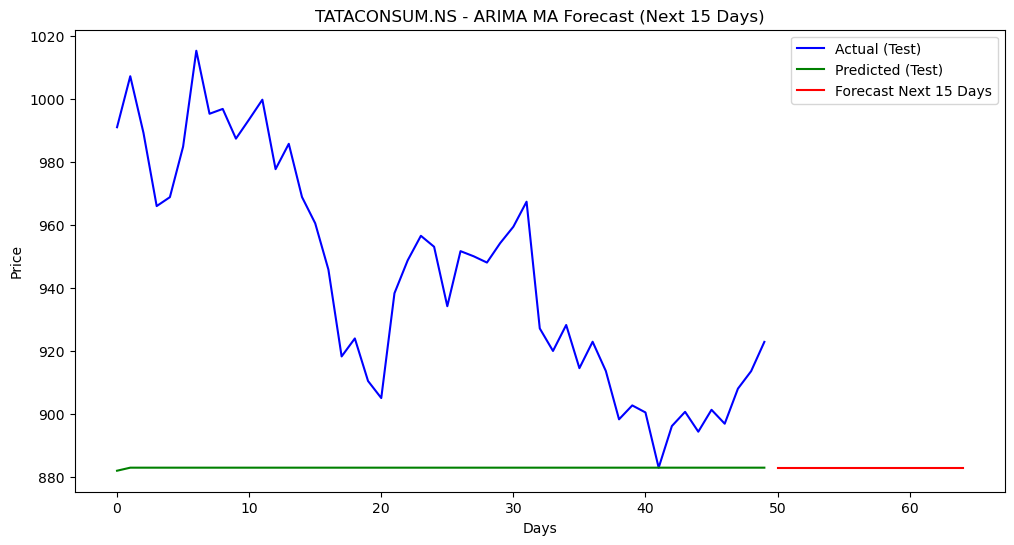

In [3]:
# ========================================================
# 🔮 FORECAST NEXT 15 DAYS WITH ARIMA MA MODEL
# ========================================================

future_steps = 15

# Predict beyond the last known data
future_pred_scaled = final_model.predict(
    start=len(data1),
    end=len(data1) + future_steps - 1
)

# reshape
future_pred_scaled = np.array(future_pred_scaled).reshape(-1,1)

# inverse transform to real price
future_pred_real = Ms.inverse_transform(future_pred_scaled)

print("\n============================")
print("📈 NEXT 15 DAYS FORECAST (REAL PRICES)")
print("============================\n")

for i, price in enumerate(future_pred_real):
    print(f"Day +{i+1}: ₹{price[0]:.2f}")


# ========================================================
# 📊 PLOT FORECAST
# ========================================================

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual (Test)", color='blue')
plt.plot(final_pred_real, label="Predicted (Test)", color='green')
plt.plot(
    range(len(y_test_real), len(y_test_real) + future_steps),
    future_pred_real,
    label="Forecast Next 15 Days",
    color='red'
)

plt.title("TATACONSUM.NS - ARIMA MA Forecast (Next 15 Days)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()
